<a href="https://colab.research.google.com/github/SowruvMinhajTaher/First-Repository/blob/main/transfer_learning_scaling_up_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Mon Jun 14 09:17:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## creating helper functions
# in previous notebook we have created helper functions 
#downloading them
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-14 09:17:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-14 09:17:41 (70.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

#101 food classes working with less data
our goal is to beat the original food101 paper with 10% of the training data, so lets download it

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2021-06-14 09:17:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   108MB/s    in 17s     

2021-06-14 09:18:02 (90.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
train_dir = '/content/101_food_classes_10_percent/train'
test_dir = '/content/101_food_classes_10_percent/test'

In [7]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_quesadilla'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/filet_mignon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_onion_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 

In [8]:
# setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big dog model with transfer learning on 10% of 101 food classes

In [9]:
# create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights= True,
                                                         monitor='val_accuracy',
                                                         save_best_only='True')

# create a data augmentation layer

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


#Data augmentation
data_augmentation = Sequential([
                                preprocessing.RandomFlip('horizontal'),
                                preprocessing.RandomRotation(.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomZoom(0.2),
                                #preprocessing.Rescaling(1/255) # rescale input of images..efficient net came with build in rescaling
], name="data_augmentation")

# Build a headless (no top layers) Functional EfficientNetB0 backboned model(we will create our own output layer)
# setup the base_model and freeze its layers (this will extract features)

In [11]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)# augment images (only happens during training phase)
x = base_model(x,training=False)# put the base model in inference mode so which weights need to be frozen stay frozen
x = layers.GlobalAveragePooling2D(name = "global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation = 'softmax', name = 'output_layer')(x)

model = tf.keras.Model(inputs,outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit
history_all_class_10_percent = model.fit(train_data_all_10_percent,
                                         epochs = 5,
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 168s 566ms/step - loss: 3.4673 - accuracy: 0.2496 - val_loss: 2.6866 - val_accuracy: 0.3774


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: 101_classes_10_percent_data_model_checkpoint/assets
Epoch 2/5
237/237 [==============================] - 107s 450ms/step - loss: 2.3425 - accuracy: 0.4619 - val_loss: 2.2352 - val_accuracy: 0.4653


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: 101_classes_10_percent_data_model_checkpoint/assets
Epoch 3/5
237/237 [==============================] - 105s 441ms/step - loss: 1.9848 - accuracy: 0.5283 - val_loss: 2.1229 - val_accuracy: 0.4621
Epoch 4/5
237/237 [==============================] - 97s 406ms/step - loss: 1.7618 - accuracy: 0.5773 - val_loss: 2.0034 - val_accuracy: 0.4820


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: 101_classes_10_percent_data_model_checkpoint/assets
Epoch 5/5
237/237 [==============================] - 91s 383ms/step - loss: 1.6031 - accuracy: 0.6073 - val_loss: 1.9699 - val_accuracy: 0.4844


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: 101_classes_10_percent_data_model_checkpoint/assets


In [14]:
# Evaluate on the whole test dataset
feature_extraction_results= model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 144s 182ms/step - loss: 1.7243 - accuracy: 0.5491


[1.7242668867111206, 0.5491089224815369]

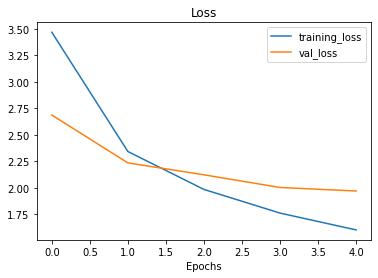

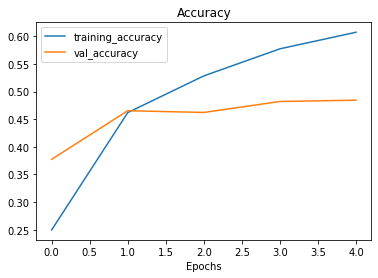

In [15]:
plot_loss_curves(history_all_class_10_percent)

#Fine-tuining

In [16]:
#unfreeze all of the layers in the base model
base_model.trainable = True
# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [17]:
# Recompile model with lower learning rate(as we are doing fine tuning)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
# what layers in the model are trainable
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [19]:
# check which layers are trainable in base model
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [22]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs(feature extraction), this is total number of epochs we are after(5+5)=10
#Fine tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch=history_all_class_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 101s 390ms/step - loss: 1.3679 - accuracy: 0.6416 - val_loss: 1.8937 - val_accuracy: 0.5013
Epoch 6/10
237/237 [==============================] - 88s 371ms/step - loss: 1.2380 - accuracy: 0.6741 - val_loss: 1.8879 - val_accuracy: 0.5090
Epoch 7/10
237/237 [==============================] - 83s 351ms/step - loss: 1.1617 - accuracy: 0.6924 - val_loss: 1.9324 - val_accuracy: 0.4971
Epoch 8/10
237/237 [==============================] - 80s 337ms/step - loss: 1.0932 - accuracy: 0.7117 - val_loss: 1.9177 - val_accuracy: 0.5069
Epoch 9/10
237/237 [==============================] - 82s 345ms/step - loss: 1.0288 - accuracy: 0.7207 - val_loss: 1.9248 - val_accuracy: 0.5037
Epoch 10/10
237/237 [==============================] - 81s 341ms/step - loss: 0.9833 - accuracy: 0.7376 - val_loss: 1.9169 - val_accuracy: 0.5032


In [23]:
# Evaluate on the whole dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 142s 179ms/step - loss: 1.6299 - accuracy: 0.5725


[1.629874587059021, 0.5725148320198059]

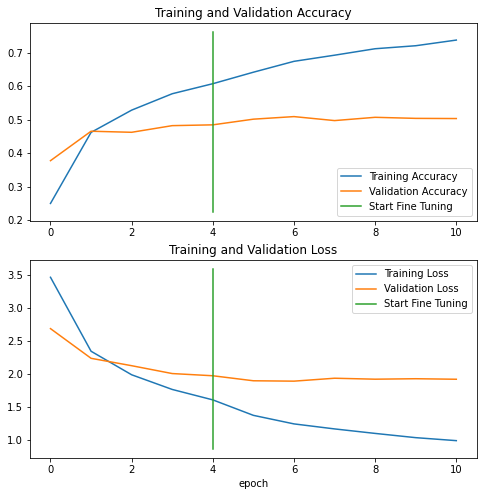

In [25]:
# compare the history of feature extraction model with 
compare_historys(original_history=history_all_class_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

# Saving and loading our model
To use our model in external application, we will need to save it and export it somewhere

In [28]:
# Save or fine tuning model
model.save('drive/MyDrive/Projects.101_classes_food_model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/Projects.101_classes_food_model/assets


In [30]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/Projects.101_classes_food_model')

In [31]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 148s 185ms/step - loss: 1.6299 - accuracy: 0.5725


[1.629874587059021, 0.5725148320198059]

In [32]:
all_classes_10_percent_fine_tune_results

[1.629874587059021, 0.5725148320198059]